In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)

So in the last time we're able to "softly" label ~54% of the dataset based on 2 features which are `male_items` and `female_items`. However, other features might also contribute to the gender, however other features is not clear in a way that we can intepret, we don't even have labels! This is where deep learning shines. 
Later, we will build a representation model on contrastive learning "softly" labeled data. Then use that to predict the other half uncertainty.

For now we're preparing some useful features for the model.

# 1. Load data

In [2]:
with open("clean_data.csv", "r") as f:
    df = pd.read_csv(f)
with open("partial_labels.csv","r") as f:
    partial_labels_df = pd.read_csv(f)

In [3]:
partial_labels_df

,female_flag,customer_id
0,0,3.017372e+09
1,0,3.018459e+09
2,0,3.020737e+09
3,0,3.020872e+09
4,0,3.020897e+09
...,...,...
103805,1,3.706458e+09
103806,1,3.706571e+09
103807,1,3.706577e+09
103808,1,3.706952e+09


In [4]:
# Merge df with label
main_df = pd.merge(df, partial_labels_df, how="right", left_on="customer_id", right_on="customer_id")

# Drop redundant key label after merged
main_df.orders

0          21
1          10
2           8
3           5
4           3
         ... 
103805      8
103806      9
103807     16
103808      3
103809    187
Name: orders, Length: 103810, dtype: int64

In [5]:
main_df.keys()

Index(['days_since_first_order', 'days_since_last_order',
       'is_newsletter_subscriber', 'orders', 'items', 'returns',
       'different_addresses', 'shipping_addresses', 'devices', 'vouchers',
       'cc_payments', 'paypal_payments', 'afterpay_payments', 'female_items',
       'male_items', 'unisex_items', 'wapp_items', 'wftw_items', 'mapp_items',
       'wacc_items', 'macc_items', 'mftw_items', 'sprt_items', 'msite_orders',
       'desktop_orders', 'android_orders', 'ios_orders', 'work_orders',
       'home_orders', 'parcelpoint_orders', 'coupon_discount_applied',
       'revenue', 'customer_id', 'female_flag'],
      dtype='object')

# 2. Feature engineering

Column days_since_first_order
Column days_since_last_order
Column orders
Column items
Column returns


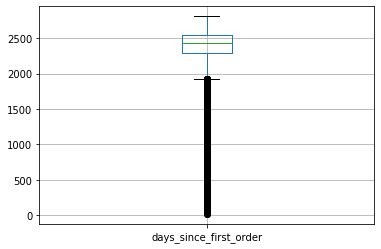

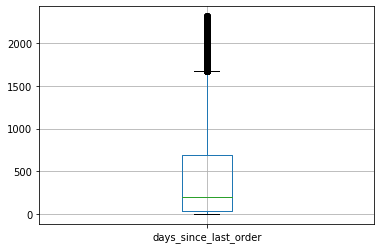

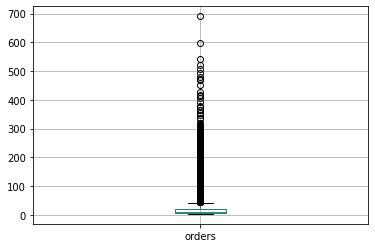

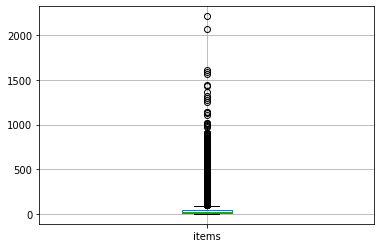

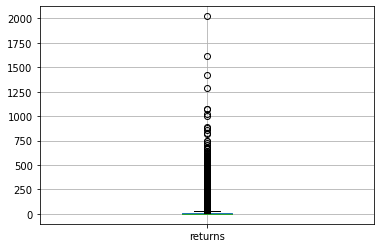

In [6]:
# skip visualize due to categorical object
skip_columns = ['is_newsletter_subscriber','customer_id','female_flag']
top_n = 5
i = 0
for column in main_df:
    if i == top_n:
        break
    elif column in skip_columns:
        continue
    print(f"Column {column}")
    plt.figure()
    main_df.boxplot([column])
    i += 1

From few boxplots we can see that the outliers deviates from the mean a lot. This is due to the nature of accumulative values.

For example:
- returns is accumulative value since because it rises after customer return an order but do not decrease by any mean.
- this kind of feature is not useful because it does not reflect users buying habit. 
- to reflect accurately the user habit we should relate it to the another "time span" variable. For example, returns per order, or returns per items, etc.
    

Here we introduce some features normalized with the "time span" variable (for example `orders` or `items`) to reflect correctly the users behaviors

In [7]:
def map_newsletter(x):
    if x == "Y":
        return 1
    elif x == "N":
        return 0
    else:
        return x

In [8]:
# 0. Map to 0/1
df["is_newsletter_subscriber"] = df["is_newsletter_subscriber"].apply(map_newsletter)

# 1. Per order

## General
main_df["items_per_order"] = main_df["items"]/main_df["orders"]
main_df["vouchers_per_order"] = main_df["vouchers"]/main_df["orders"]
main_df["male_items_per_order"] = main_df["male_items"]/main_df["orders"]
main_df["unisex_items_per_order"]= main_df["unisex_items"]/main_df["orders"]
main_df["female_items_per_order"] = main_df["male_items"]/main_df["orders"]
main_df["revenue_per_order"] = main_df["revenue"]/main_df["orders"]

## Purchase platform
main_df["msite_orders_rate"] = main_df["msite_orders"]/main_df["orders"]
main_df["desktop_orders_rate"] = main_df["desktop_orders"]/main_df["orders"]
main_df["android_orders_rate"]= main_df["android_orders"]/main_df["orders"]
main_df["ios_orders_rate"] = main_df["ios_orders"]/main_df["orders"]

## Different address
main_df["shipping_addresses_rate"] = main_df["shipping_addresses"]/main_df["orders"]


## Place of order
main_df["home_orders_rate"] = main_df["home_orders"]/main_df["orders"]
main_df["parcelpoint_orders_rate"] = main_df["parcelpoint_orders"]/main_df["orders"]
main_df["work_orders_rate"] = main_df["work_orders"]/main_df["orders"]
                                                                      
# 2. Per day
main_df["items_per_day"] = main_df["items"]/(main_df["days_since_first_order"] - main_df["days_since_last_order"]+1)
main_df["orders_per_day"] = main_df["orders"]/(main_df["days_since_first_order"] - main_df["days_since_last_order"]+1)

# 3. Per item


# Returns
main_df["returns_per_item"] = main_df["returns"]/main_df["items"] 

# Different address were per items
main_df["different_addresses_rate"] = main_df["different_addresses"]/main_df["items"]

## Items
# (I realized that "return" is number of items return not orders)
main_df["male_items_rate"] = main_df["male_items"]/main_df["items"] 
main_df["female_items_rate"] = main_df["female_items"]/main_df["items"] 
main_df["unisex_items_rate"] = main_df["unisex_items"]/main_df["items"]
main_df["wapp_items_rate"] = main_df["wapp_items"]/main_df["items"]
main_df["wftw_items_rate"] = main_df["wftw_items"]/main_df["items"]
main_df["mapp_items_rate"] = main_df["mapp_items"]/main_df["items"]
main_df["wacc_items_rate"] = main_df["wacc_items"]/main_df["items"]
main_df["macc_items_rate"] = main_df["macc_items"]/main_df["items"]
main_df["mftw_items_rate"] = main_df["mftw_items"]/main_df["items"]
main_df["sprt_items"] = main_df["sprt_items"]/main_df["items"]
             
## Purchase method
# (I realized that payment methods were per items)
main_df["cc_payments_rate"] = main_df["cc_payments"]/main_df["items"]
main_df["paypal_payments_rate"]  = main_df["paypal_payments"]/main_df["items"]
main_df["afterpay_payments_rate"] = main_df["afterpay_payments"]/main_df["items"]

## Revenue
main_df["revenue_per_items"] = main_df["revenue"]/main_df["items"]


In [10]:
# Get engineered data
engineered_df = main_df.iloc[:,33:]

# Also append column "devices" and "coupon_discount_applied" into
engineered_df = pd.concat([engineered_df, main_df.loc[:,["coupon_discount_applied","devices","customer_id"]]],axis=1)

In [11]:
engineered_df.describe()

,female_flag,items_per_order,vouchers_per_order,male_items_per_order,unisex_items_per_order,female_items_per_order,revenue_per_order,msite_orders_rate,desktop_orders_rate,android_orders_rate,ios_orders_rate,shipping_addresses_rate,home_orders_rate,parcelpoint_orders_rate,work_orders_rate,items_per_day,orders_per_day,returns_per_item,different_addresses_rate,male_items_rate,female_items_rate,unisex_items_rate,wapp_items_rate,wftw_items_rate,mapp_items_rate,wacc_items_rate,macc_items_rate,mftw_items_rate,cc_payments_rate,paypal_payments_rate,afterpay_payments_rate,revenue_per_items,coupon_discount_applied,devices,customer_id
count,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,103810.000000,1.038100e+05
mean,0.852885,2.137805,0.305370,0.370998,0.074927,0.370998,128.136698,0.277079,0.565013,0.017418,0.140490,0.325033,0.515995,0.008111,0.095740,0.022767,0.010352,0.218747,0.053414,0.162008,0.798127,0.039865,0.503633,0.203905,0.094046,0.074136,0.036150,0.049293,0.541054,0.332890,0.106534,63.821084,0.106228,1.972469,3.373555e+09
std,0.354222,1.008227,0.223671,0.840721,0.134899,0.840721,69.475322,0.309759,0.345360,0.087086,0.242613,0.225657,0.329801,0.057139,0.209630,0.074205,0.040196,0.213575,0.137220,0.315440,0.331419,0.078220,0.300835,0.209386,0.214058,0.108045,0.085427,0.124223,0.393980,0.374008,0.225048,28.534945,0.100649,0.725138,2.084696e+08
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,13.013333,0.000000,0.000000,0.000000,0.000000,0.001848,0.000000,0.000000,0.000000,0.001108,0.001092,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.348407,0.000000,1.000000,3.016870e+09
25%,1.000000,1.473684,0.142857,0.000000,0.000000,0.000000,84.970294,0.000000,0.250000,0.000000,0.000000,0.150000,0.250000,0.000000,0.000000,0.005741,0.003218,0.000000,0.000000,0.000000,0.827586,0.000000,0.285714,0.037037,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,44.907381,0.028300,1.000000,3.189497e+09
50%,1.000000,1.916667,0.285714,0.000000,0.000000,0.000000,112.994914,0.166667,0.600000,0.000000,0.000000,0.272727,0.545455,0.000000,0.000000,0.011753,0.005875,0.166667,0.000000,0.000000,0.938910,0.000000,0.574468,0.153846,0.000000,0.035714,0.000000,0.000000,0.571429,0.162162,0.000000,58.777924,0.085100,2.000000,3.376838e+09
75%,1.000000,2.500000,0.444444,0.222222,0.105263,0.222222,151.992458,0.469697,0.891892,0.000000,0.200000,0.444444,0.800000,0.000000,0.032258,0.024381,0.011019,0.348837,0.024096,0.111111,1.000000,0.050000,0.733333,0.290323,0.051282,0.111111,0.031915,0.035088,1.000000,0.666667,0.055556,76.533176,0.157400,2.000000,3.551605e+09
max,1.000000,22.400000,1.000000,16.666667,3.409091,16.666667,1358.600000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,5.000000,1.000000,1.000000,1.000000,1.000000,0.857143,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,498.185000,0.990500,4.000000,3.801194e+09


Okay so we have most data scaled between 0 and 1. That's a great signal. For other column, outlier might be a problem. But no worry, we will use RobustScaler to scale it down without being suffered from largely deviated outliers.

In [12]:
engineered_df.to_csv("engineered_data.csv",index=False)